In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@consts begin
    λ = 626e-9
    Γ = 2π * 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

In [3]:
# create basis states
ground_state = AngularMomentumState_Labelled(L=0, N=1, M=-1)
excited_state = AngularMomentumState_Labelled(L=1, N=0, M=0)
basis = [ground_state; excited_state]
;

In [4]:
# create Hamiltonian
operator = :(
    T * L +
    Bz * Zeeman_L0
)

parameters = @params begin
    T = 4.789016900958466e14
    Bz = 1e-6
end

H = Hamiltonian(basis=basis, operator=operator, parameters=parameters)
;

In [5]:
# solve the Hamiltonian
evaluate!(H)
QuantumStates.solve!(H)
states = H.states

# calculate the transition dipole moments
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
;

In [220]:
s

46874.99999999999

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

In [206]:
# beam parameters
δ_ = 125Γ
# s = (sqrt(3/2) * δ_ / (Γ * maximum(norm.(d))))^2 * 2 # Ω = sqrt(3/2)*δ
s = (δ_ / (Γ * maximum(norm.(d))))^2 # Ω = δ

ϵ_func(ϵ) = t -> ϵ
s_func(s) = (r,t) -> s

ω01 = 2π * energy(H.states[2]) # σ⁺ drives to state 3

### 4-COLOR FORCE ###

Δ1 = 0Γ #+ 10Γ
Δ2 = 0Γ #+ 10Γ
χ1 = +π/6
χ2 = -π/6

## BCF FORCE BEAMS ##
# ingoing beam
ω1 = ω01 + δ_ + Δ1; k1 = +ẑ; ϵ1 = exp(+im*χ1/2) .* σ⁺; laser1 = Field(k1, ϵ_func(ϵ1), ω1, s_func(s))
ω2 = ω01 - δ_ + Δ1; k2 = +ẑ; ϵ2 = exp(-im*χ1/2) .* σ⁺; laser2 = Field(k2, ϵ_func(ϵ2), ω2, s_func(s))

# retro beam
ω3 = ω01 + δ_ - Δ1; k3 = -ẑ; ϵ3 = exp(-im*χ1/2) .* σ⁺; laser3 = Field(k3, ϵ_func(ϵ3), ω3, s_func(s))
ω4 = ω01 - δ_ - Δ1; k4 = -ẑ; ϵ4 = exp(+im*χ1/2) .* σ⁺; laser4 = Field(k4, ϵ_func(ϵ4), ω4, s_func(s))

## EXTRA BEAMS FOR 4-COLOR ##
ω9 = ω01 + 3δ_ + Δ1; k9 = +ẑ; ϵ9 = exp(+im*χ1/2) .* σ⁺; laser9 = Field(k9, ϵ_func(ϵ9), ω9, s_func(s))
ω10 = ω01 - 3δ_ + Δ1; k10 = +ẑ; ϵ10 = exp(-im*χ1/2) .* σ⁺; laser10 = Field(k10, ϵ_func(ϵ10), ω10, s_func(s))

# retro beam
ω11 = ω01 + 3δ_ - Δ1; k11 = -ẑ; ϵ11 = exp(-im*χ1/2) .* σ⁺; laser11 = Field(k11, ϵ_func(ϵ11), ω11, s_func(s))
ω12 = ω01 - 3δ_ - Δ1; k12 = -ẑ; ϵ12 = exp(+im*χ1/2) .* σ⁺; laser12 = Field(k12, ϵ_func(ϵ12), ω12, s_func(s))

lasers = [laser1, laser2, laser3, laser4, laser9, laser10, laser11, laser12]
;

In [207]:
using LoopVectorization
function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
#     Zeeman_Hx = p.extra_data.Zeeman_Hx
#     Zeeman_Hy = p.extra_data.Zeeman_Hy

#     Bx = p.sim_params.B_offset[1]
#     By = p.sim_params.B_offset[2]
    Bz = p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        # H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        # H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
        H.re[i] = Bz * Zeeman_Hz.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [208]:
Zeeman_z(state, state′) = Zeeman_L0(state, state′, 0)
Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, [H.states[1]], [H.states[2]]) .* (2π*gS/Γ))

extra_data = MutableNamedTuple(
    # Zeeman_Hx = Zeeman_x_mat,
    # Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat,
    lasers = lasers,
    states = states
)
sim_params = MutableNamedTuple(
    B_offset = (0., 0., 20.)
    )
;

In [209]:
# Set initial conditions
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0
    
freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, true, true; 
    sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, freq_res=freq_res, update_H_and_∇H=update_H_and_∇H)

p.r0 = (0., 0., 0.) .* 2π
p.v = (0., 0., 5.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)

t_end = 2p.period+1
tspan = (0., t_end)

# prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)

prob = ODEProblem(ρ_updated!, p.ρ0_vec, tspan, p, callback=cb)
times = range(0, t_end, 10000)
;

In [210]:
# using BenchmarkTools
# dρ = deepcopy(p.ρ0_vec)
# @btime ρ_updated!($dρ, $p.ρ0_vec, $p, 0.0)

In [211]:
@time sol = DifferentialEquations.solve(prob, DP5(), reltol=1e-3, saveat=times)
;

  3.215765 seconds (3.98 M allocations: 262.880 MiB, 4.09% gc time, 94.52% compilation time)


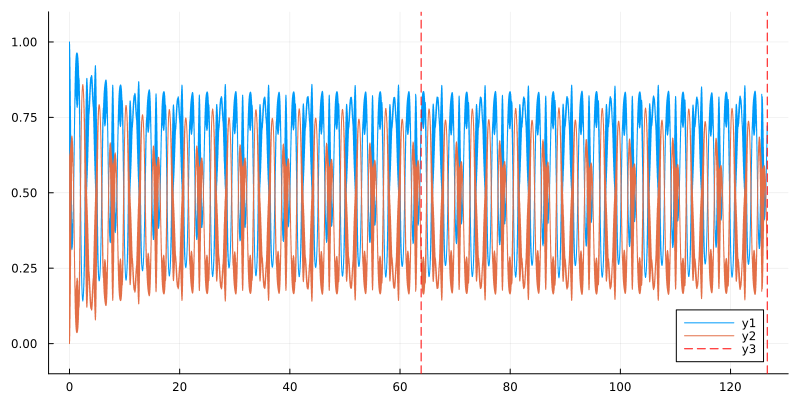

In [212]:
using Plots
plot_us = sol.u#[1:100:end]
plot_ts = sol.t#[1:100:end]

n_states = size(prob.p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1))
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
# plot!(plot_ts, [real(u[end]) for u in plot_us])
# plot!(plot_ts, [real(u[end-1]) for u in plot_us])
# plot!(plot_ts, [real(u[end-2]) for u in plot_us])
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [213]:
prob.p.force_last_period #* (1e-3 * ħ * k * Γ / m)

3-element SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.0
 -0.12900691922336321

## Force versus velocity

In [214]:
function prob_func(prob, i, repeat)
    prob.p.v = (0., 0., scan_params[i].v)
    prob.p.force_last_period = SVector(0.,0.,0.)
    return prob
end
function output_func(sol, i)
    f = sol.prob.p.force_last_period
    return (f, false) #[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [215]:
using RectiGrids

di = 0
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = (-30:0.25:30) #./ (Γ / k)

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
scan_params = scan_values_grid
;

In [216]:
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleThreads(), trajectories=length(scan_params), reltol=1e-4, save_on=false)
;

  5.678399 seconds (1.59 M allocations: 109.639 MiB, 0.45% gc time, 521.88% compilation time)


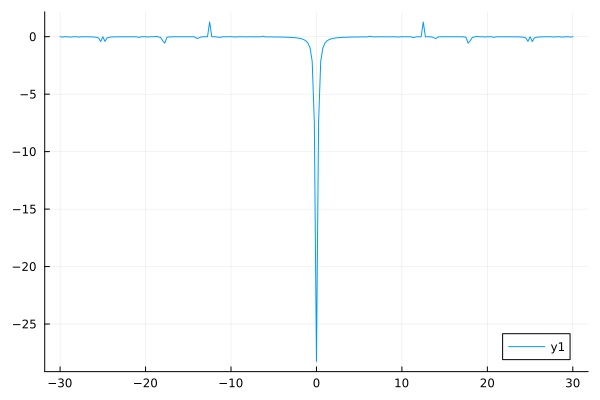

In [217]:
plot(vs, [sol.prob.p.force_last_period[3] for sol ∈ ensemble_sol] .* 2)

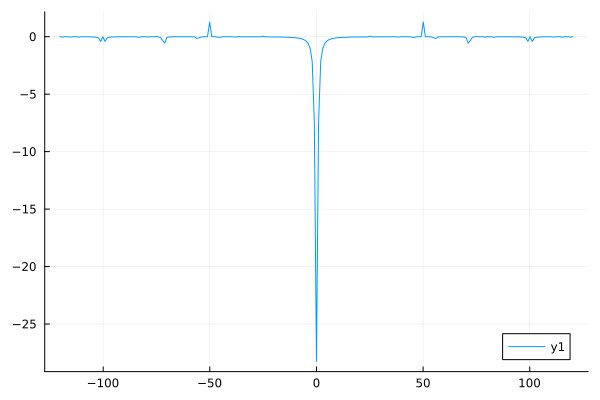

In [218]:
plot(vs .* (Γ / k), [sol.prob.p.force_last_period[3] for sol ∈ ensemble_sol] .* 2)

## Force versus magnetic field

In [257]:
function prob_func(prob, i, repeat)
    # p = prob.p
    
#     new_p = obe(p.ρ0, p.particle, p.extra_data.states, p.extra_data.lasers, p.d, true, true; 
#         sim_params=p.sim_params, extra_data=p.extra_data, λ=p.λ, Γ=p.Γ, freq_res=p.freq_res, update_H_and_∇H=p.update_H_and_∇H
#         )
    
#     # Update velocity, position
    # new_p.v .= scan_params[i].v
#     new_p.r0 .= scan_params[i].r
    
    # Ensure that frequencies and velocities are rounded
    # round_params(new_p)
    
    prob.p.v .= scan_params[i].v
    prob.p.force_last_period = SVector(0.,0.,0.)
    
    # Solve Hamiltonian for new `Bz` value
    prob.p.sim_params.B_offset = (0, 0, scan_params[i].Bz)
    
    # new_prob = remake(prob, p=new_p)
    
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(sol, i)
    f = sol.prob.p.force_last_period
    return (f, false) #[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [258]:
scan_params[6]

(r = (0.0, 0.0, 0.0), v = -25)

In [259]:
using RectiGrids

Bs = -50:0.3:50 #[reverse(-(0:1:10.)); 0:1:10]
di = 0
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [(+0.3, 0., 0.) ./ (Γ / k), (-0.3, 0., 0.) ./ (Γ / k)]; #[sample_direction(0.1) for _ in 1:10]

scan_values = (Bz = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [260]:
ensemble_sol[6].prob.p.sim_params

MutableNamedTuple(B_offset = (0.0, 0.0, 20.0),)

In [261]:
scan_params = scan_values_grid
;

In [262]:
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
;

In [ ]:
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleThreads(), trajectories=length(scan_params))
;

In [ ]:
[sol.prob.p.force_last_period[1] for sol ∈ ensemble_sol]

In [ ]:
forces = [sol.prob.p.force_last_period[1] for sol ∈ ensemble_sol]
;

In [ ]:
plot(Bs, forces[1:334] .+ forces[335:end])

In [ ]:
plot([sol.prob.p.force_last_period[1] for sol ∈ ensemble_sol])

In [789]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.Bz == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

LoadError: UndefVarError: `forces` not defined

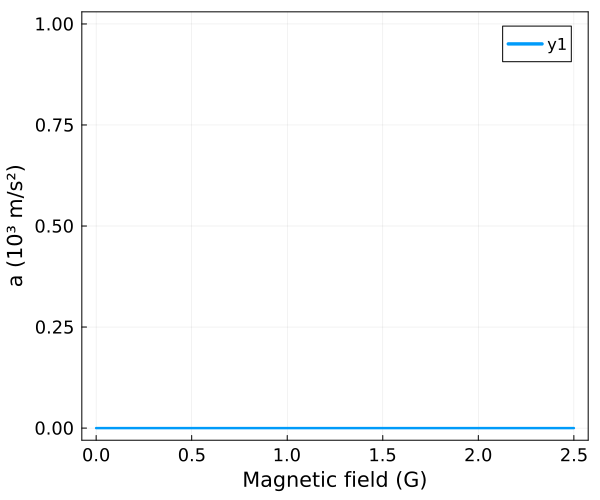

In [32]:
plot(Bs, (1e-3 * ħ * k * Γ / m) .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(0,20),
    size=(600,500)
    )

In [48]:
Bzs, averaged_populations_magnetic = average_values(scan_params, populations)
plot(Bzs, sum(averaged_populations_magnetic[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    ylim=(0,1),
    size=(600,500),
    label="Excited"
    )
plot!(Bzs, sum(averaged_populations_magnetic[:,1:3], dims=2), linewidth=2.5, label="F=1-")
plot!(Bzs, sum(averaged_populations_magnetic[:,4], dims=2), linewidth=2.5, label="F=0")
plot!(Bzs, sum(averaged_populations_magnetic[:,5:7], dims=2), linewidth=2.5, label="F=1+")
plot!(Bzs, sum(averaged_populations_magnetic[:,8:12], dims=2), linewidth=2.5, label="F=2")

LoadError: UndefVarError: `scan_params` not defined

In [49]:
Γ .* sum(averaged_populations_magnetic[:,13:16], dims=2)

LoadError: UndefVarError: `averaged_populations_magnetic` not defined

## Force versus velocity

In [60]:
using StaticArrays

In [3288]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= (0, 0, scan_values.v[i]) ./ (prob.p.Γ / prob.p.k)
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return f[3]
end
;

In [3289]:
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

n_samples = 40

vs = repeat([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], n_samples)
# vs = repeat([collect(0:0.02:0.1); collect(0.2:0.2:5.0)], n_samples)
# vs = [reverse(-vs); vs]

scan_values = (v = vs,)
;

In [3290]:
@time scan_params, forces, populations_velocity = force_scan(prob, scan_values, prob_func!, param_func, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


 26.670844 seconds (4.64 M allocations: 341.490 MiB, 1.07% gc time, 667.16% compilation time)


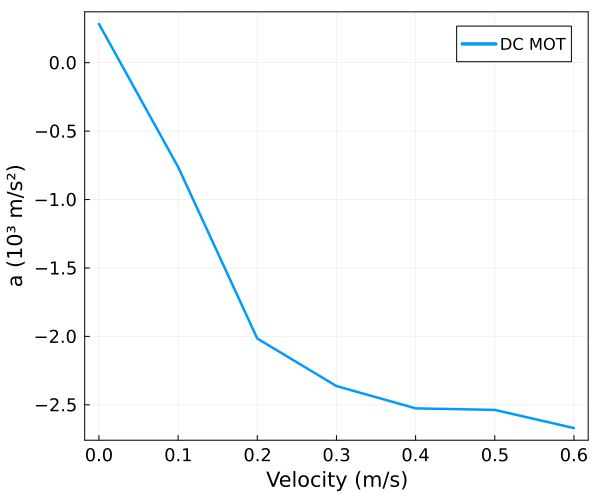

In [3291]:
vs, averaged_forces_velocity, stddev_velocity = average_values(scan_params, forces)
plot(vs, (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-8,6),
    label="DC MOT",
    size=(600,500)
    )

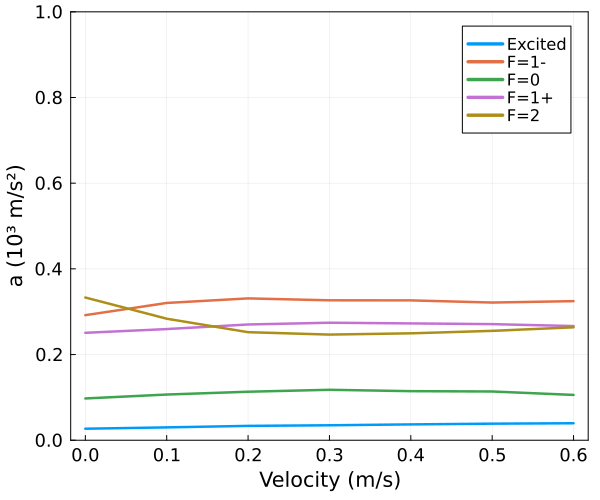

In [3292]:
vs, averaged_populations_velocity = average_values(scan_params, populations_velocity)
plot(vs, sum(averaged_populations_velocity[:,13:16], dims=2), 
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(0,1),
    size=(600,500),
    label="Excited"
    )
plot!(vs, sum(averaged_populations_velocity[:,1:3], dims=2), linewidth=2.5, label="F=1-")
plot!(vs, sum(averaged_populations_velocity[:,4], dims=2), linewidth=2.5, label="F=0")
plot!(vs, sum(averaged_populations_velocity[:,5:7], dims=2), linewidth=2.5, label="F=1+")
plot!(vs, sum(averaged_populations_velocity[:,8:12], dims=2), linewidth=2.5, label="F=2")

In [3293]:
Γ .* sum(averaged_populations_velocity[:,13:16], dims=2)

7×1 Matrix{Float64}:
 1.078988208810097e6
 1.2041856779331528e6
 1.3459233043071234e6
 1.4028134581583368e6
 1.4846965706537266e6
 1.5534173221810833e6
 1.5929833494489414e6

# Prepare interpolation for Monte Carlo simulations

In [3191]:
using RectiGrids

In [3192]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values[i].B
    vx = scan_values[i].vx
    vy = scan_values[i].vy
    vz = scan_values[i].vz
    
    if p.extra_p.HX.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_p.HX.parameters.B_z = Bz 
        evaluate!(p.extra_p.HX)
        QuantumStates.solve!(p.extra_p.HX)
        for i ∈ eachindex(p.extra_p.HX.states)
            p.extra_p.HX.states[i].E *= 1e6
        end
        
        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX.states[5:16], p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX.states[5:16]; p.extra_p.states_A_J12_caseB]

        extra_p = (
            basis_tdms=p.extra_p.basis_tdms, 
            HX=p.extra_p.HX, 
            d_ge=p.extra_p.d_ge, 
            reduced_A_J12_caseB_basis=p.extra_p.reduced_A_J12_caseB_basis, 
            states_A_J12_caseB=p.extra_p.states_A_J12_caseB)
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= (vx, vy, vz)
    new_p.r0 .= rand(uniform_dist, 3)
    new_p.fields.ω .= p.fields.ω
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [3193]:
freq_res = 1e-1
extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge, reduced_A_J12_caseB_basis=reduced_A_J12_caseB_basis, states_A_J12_caseB=states_A_J12_caseB)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 20p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)
;

In [595]:
grid_range_B = 0:4.:40
grid_range_vx = 0.:0
grid_range_vy = 0.:0
grid_range_vz = -10:0.1:10

n_samples = 100

scan_values = (B = grid_range_B, vx = grid_range_vx, vy = grid_range_vy, vz = grid_range_vz)
scan_values_grid = RectiGrids.grid(scan_values)
scan_values_grid_n = RectiGrids.grid((i = 1:n_samples, scan_values...))
;

In [ ]:
forces, populations = force_scan_v2(prob, scan_values_grid_n, prob_func!, output_func)
;

LoadError: InterruptException:

Progress:   0%|█                                        |  ETA: 1:04:13

In [597]:
using DataFrames
df = select!(DataFrame(scan_values_grid_n), keys(scan_values)...)
df.force_x = [x[1] for x ∈ forces]
df.force_y = [x[2] for x ∈ forces]
df.force_z = [x[3] for x ∈ forces]
;

Progress:   0%|█                                        |  ETA: 1:04:16

InterruptException: InterruptException:

In [598]:
gdf = groupby(df, :B)
force_means = combine(gdf,
    :force_x => mean, 
    :force_y => mean,
    :force_z => mean
    )

LoadError: UndefVarError: `groupby` not defined

Progress:   3%|██                                       |  ETA: 0:56:36

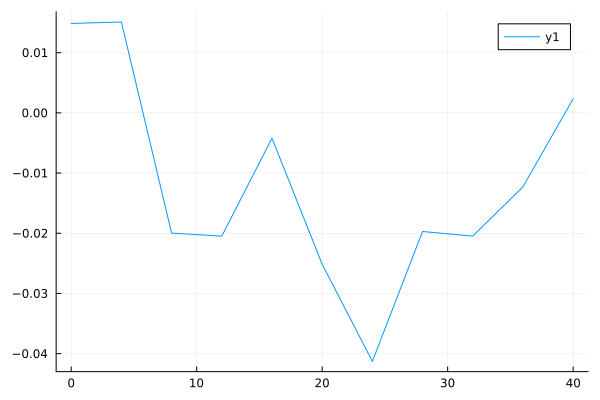

In [244]:
plot(force_means.B, (1e-3 * ħ * k * Γ / m) .* force_means.force_z_mean)